In [9]:
import pandas as pd
import boto3
import os

# --- 1. Configuración de Rutas en S3 ---
# 🚨 ¡Actualiza estas 4 variables con tus datos!

# Bucket donde se encuentra el archivo ORIGINAL
source_bucket = 'datos-iot-fisi' 
# Ruta completa (prefijo + nombre) del archivo ORIGINAL
source_key = 'results (1).csv' 

# Bucket donde se guardará el archivo PROCESADO (puede ser el mismo)
destination_bucket = 'datos-iot-fisi'
# Carpeta (prefijo) donde se guardará el archivo PROCESADO
destination_prefix = 'calidad-aire/datos-procesados'

# --- No es necesario cambiar nada debajo de esta línea ---

# Nombre del archivo local (temporal)
local_filename = os.path.basename(source_key)

try:
    # --- 2. Descargar el Archivo desde S3 ---
    print(f"Descargando 's3://{source_bucket}/{source_key}' a la instancia local...")
    s3_client = boto3.client('s3')
    s3_client.download_file(source_bucket, source_key, local_filename)
    print("¡Archivo descargado con éxito!")

    # --- 3. Cargar y Procesar los Datos con Pandas ---
    print(f"\nCargando el archivo '{local_filename}' para procesarlo...")
    df = pd.read_csv(local_filename)

    # Ingeniería de Características para 'timestamp'
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['hora_del_dia'] = df['timestamp'].dt.hour
    df['dia_de_la_semana'] = df['timestamp'].dt.dayofweek
    df['mes'] = df['timestamp'].dt.month
    df = df.drop('timestamp', axis=1)

    # Drop estado del aire
    df = df.drop('estado_aire', axis=1)

    #pequeña limpieza temperatura = '-10
    df = df[df['temperature'] != '\'-10']
    
    print("Procesamiento de datos completado.")

    # --- 4. Guardar y Subir el Archivo Procesado a S3 ---
    final_feature_dim = len(df.columns)
    processed_filename = 'datos_procesados_para_rcf.csv'
    
    # Guardar localmente sin encabezados ni índice
    df.to_csv(processed_filename, header=False, index=False)

    # Subir el nuevo archivo a S3
    destination_key = f"{destination_prefix}/{processed_filename}"
    print(f"\nSubiendo archivo procesado a 's3://{destination_bucket}/{destination_key}'...")
    s3_client.upload_file(processed_filename, destination_bucket, destination_key)
    
    print("-" * 50)
    print("¡PROCESO FINALIZADO! ✅")
    print(f"El archivo procesado ya está en tu bucket S3.")
    print(f"\n🚨 **Importante**: El valor para el hiperparámetro 'feature_dim' de tu modelo es: {final_feature_dim}")
    print("-" * 50)


except Exception as e:
    print(f"Ocurrió un error: {e}")

Descargando 's3://datos-iot-fisi/results (1).csv' a la instancia local...
¡Archivo descargado con éxito!

Cargando el archivo 'results (1).csv' para procesarlo...
Procesamiento de datos completado.

Subiendo archivo procesado a 's3://datos-iot-fisi/calidad-aire/datos-procesados/datos_procesados_para_rcf.csv'...
--------------------------------------------------
¡PROCESO FINALIZADO! ✅
El archivo procesado ya está en tu bucket S3.

🚨 **Importante**: El valor para el hiperparámetro 'feature_dim' de tu modelo es: 6
--------------------------------------------------


In [10]:
import pandas as pd
import numpy as np
import sagemaker
from sagemaker.amazon.amazon_estimator import RecordSet # Necesario para el formato de datos
from sagemaker import RandomCutForest # La nueva clase que estás usando

# --- 1. Configuración ---
session = sagemaker.Session()
bucket = 'datos-iot-fisi' # Definimos el bucket para más claridad
prefix = 'calidad-aire/datos-procesados' # El prefijo/carpeta
s3_path = f's3://{bucket}/{prefix}/' # SageMaker espera una ruta a la carpeta, no al archivo
file_name = 'datos_procesados_para_rcf.csv'
# Rol de ejecución
role = sagemaker.get_execution_role()

# --- 2. Cargar los datos de S3 a un DataFrame de Pandas ---
# Esta es la línea que te faltaba. 
# Pandas puede leer directamente de S3.
# Usamos header=None porque tu archivo procesado no tiene encabezados.
print("Cargando datos desde S3 a Pandas...")
s3_file_path = f's3://{bucket}/{prefix}/{file_name}'
df = pd.read_csv(s3_file_path, header=None)
print("¡Datos cargados con éxito!")
print("\nPrimeras 5 filas del DataFrame:")
print(df.head())


# --- 3. Instanciar el modelo ---
# El código que ya tenías está perfecto.
# El parámetro 'data_location' le dice al modelo dónde encontrar los datos en S3.
rcf = RandomCutForest(
    role=role,
    instance_count=1,
    instance_type='ml.m5.large',
    data_location=s3_path, # ¡Importante! Esto apunta a la carpeta en S3
    num_samples_per_tree=256,
    num_trees=100,
    sagemaker_session=session
)

# --- 4. Entrenar el modelo (con la corrección) ---
print("\nIniciando el entrenamiento...")

# Convertimos los valores del DataFrame a un array de floats y creamos el RecordSet
train_data = df.values.astype('float32')
rcf.fit(rcf.record_set(train_data))

print("¡Entrenamiento completado! ✅")

Cargando datos desde S3 a Pandas...
¡Datos cargados con éxito!

Primeras 5 filas del DataFrame:
      0   1     2   3  4  5
0  1088  75  21.0  22  2  7
1  1089  77  21.0  23  2  7
2  1044  76  21.4  23  2  7
3  1281  75  21.4  21  2  7
4  1065  77  21.0  23  2  7

Iniciando el entrenamiento...


INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: randomcutforest-2025-07-12-18-30-42-570


2025-07-12 18:30:44 Starting - Starting the training job...
2025-07-12 18:31:18 Downloading - Downloading input data......
2025-07-12 18:31:53 Downloading - Downloading the training image.........
2025-07-12 18:33:44 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:495: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cons['type'] is 'ineq':
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:743: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(self.X_min) is not 0:
[07/12/2025 18:33:51 INFO 139901168248640] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/defau

In [11]:
# --- 5. Desplegar el modelo como un endpoint ---

print("\nDesplegando el modelo en un endpoint... 🚀")

# Usamos el estimador ya entrenado para crear el endpoint.
# Para el endpoint, podemos usar una instancia más pequeña y económica.
endpoint_name = 'rcf-calidad-aire-endpoint'

rcf_predictor = rcf.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large',
    endpoint_name= endpoint_name # Nombre único para tu endpoint
)

print(f"¡Endpoint '{rcf_predictor.endpoint_name}' desplegado y listo!")

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating model with name: randomcutforest-2025-07-12-18-41-11-487



Desplegando el modelo en un endpoint... 🚀


INFO:sagemaker:Creating endpoint-config with name rcf-calidad-aire-endpoint
INFO:sagemaker:Creating endpoint with name rcf-calidad-aire-endpoint


--------!¡Endpoint 'rcf-calidad-aire-endpoint' desplegado y listo!


In [12]:
# Esta línea te mostrará la ruta exacta en S3 donde se guardó el model.tar.gz
print(rcf.output_path)

s3://sagemaker-us-east-2-581549954809/


In [18]:
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

# --- 1. Configuración del Predictor ---
# El nombre exacto de tu endpoint desplegado
endpoint_name = 'rcf-calidad-aire-endpoint' 

# Creamos un objeto Predictor genérico
predictor = Predictor(
    endpoint_name=endpoint_name,
    sagemaker_session=sagemaker.Session()
)

# 2. Le decimos cómo manejar los datos
predictor.serializer = CSVSerializer()       # Enviar los datos como CSV
predictor.deserializer = JSONDeserializer()  # Recibir la respuesta como un diccionario JSON

# --- 3. Preparar los datos de prueba ---
# Asegúrate de que tu DataFrame 'df' todavía exista
test_data = df.iloc[[0]].values

print("Enviando los siguientes datos de prueba:")
print(test_data)

# --- 4. Hacer la Predicción ---
results = predictor.predict(test_data)

print("\nResultado recibido (como diccionario):")
print(results)

# --- 5. Extraer la Puntuación del Diccionario ---
# Ahora el resultado es un diccionario predecible
anomaly_score = results['scores'][0]['score']

print("\n✅ ¡Predicción final y correcta!")
print(f"La puntuación de anomalía es: {anomaly_score:.4f}")

Enviando los siguientes datos de prueba:
[[1088.   75.   21.   22.    2.    7.]]

Resultado recibido (como diccionario):
{'scores': [{'score': 0.7317602746}]}

✅ ¡Predicción final y correcta!
La puntuación de anomalía es: 0.7318


In [ ]:
# --- 6. Limpiar recursos para evitar costos ---
print(f"\nEliminando el endpoint '{rcf_predictor.endpoint_name}'...")
rcf_predictor.delete_endpoint()
print("¡Endpoint eliminado!")

In [19]:
import pandas as pd
import numpy as np
import sagemaker
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

# --- 1. Cargar tus datos (si aún no están en un DataFrame 'df') ---
# Asegúrate de que esta sección se ejecute si reiniciaste el kernel
try:
    df
    print("El DataFrame 'df' ya existe. Omitiendo la carga.")
except NameError:
    print("Cargando datos desde S3 a Pandas...")
    bucket = 'datos-iot-fisi'
    prefix = 'calidad-aire/datos-procesados'
    file_name = 'datos_procesados_para_rcf.csv'
    s3_file_path = f's3://{bucket}/{prefix}/{file_name}'
    df = pd.read_csv(s3_file_path, header=None)
    print("¡Datos cargados con éxito!")

# --- 2. Reconectar al Endpoint ---
endpoint_name = 'rcf-calidad-aire-endpoint' 
predictor = Predictor(
    endpoint_name=endpoint_name,
    sagemaker_session=sagemaker.Session()
)
predictor.serializer = CSVSerializer()
predictor.deserializer = JSONDeserializer()

# --- 3. Calcular las puntuaciones para todo el dataset ---
print(f"\nCalculando puntuaciones para los {len(df)} registros. Esto puede tardar un momento...")

# Preparamos los datos
all_data = df.values.astype('float32')

# Invocamos el endpoint
results = predictor.predict(all_data)

# Extraemos solo las puntuaciones y las guardamos en una nueva columna del DataFrame
scores = [record['score'] for record in results['scores']]
df['anomaly_score'] = scores

print("¡Cálculo de puntuaciones completado!")

El DataFrame 'df' ya existe. Omitiendo la carga.

Calculando puntuaciones para los 1199 registros. Esto puede tardar un momento...
¡Cálculo de puntuaciones completado!


INFO:matplotlib.font_manager:generated new fontManager



--- Análisis Estadístico de las Puntuaciones de Anomalía ---
count    1199.000000
mean        0.935296
std         0.260305
min         0.662506
25%         0.744526
50%         0.889677
75%         1.028434
max         2.860998
Name: anomaly_score, dtype: float64

Generando visualizaciones...


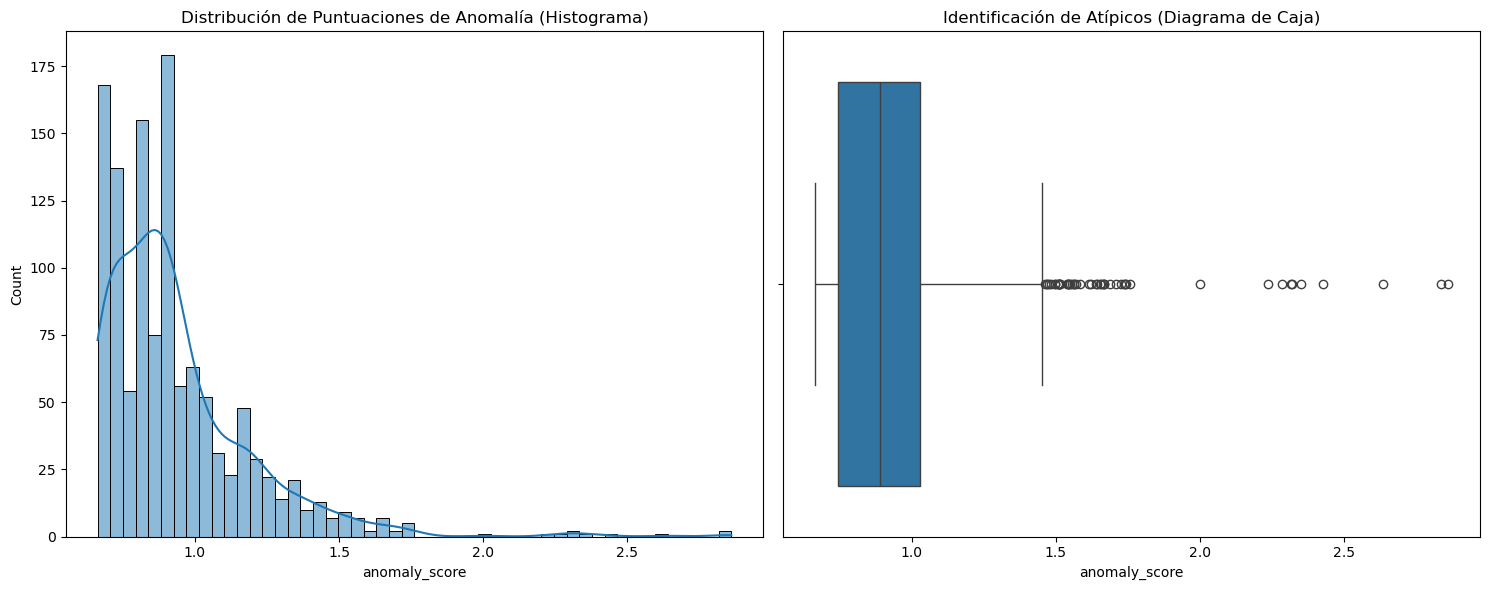


--- Top 10 Registros con Mayor Puntuación de Anomalía ---
        0   1     2   3  4  5  anomaly_score
771   220  78  21.0  23  2  7       2.860998
192   241  75  21.0  23  2  7       2.837152
470   507  77  21.0  22  2  7       2.634440
176   659  78  21.0   0  3  7       2.425329
896   704  79  20.6   0  3  7       2.350622
479   714  80  20.6   0  3  7       2.319336
526   717  78  21.0  23  2  7       2.314979
681   731  80  20.6   0  3  7       2.284783
319  1482  75  21.0  22  2  7       2.236372
394   837  77  21.0  23  2  7       2.000554


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- A. Análisis Estadístico ---
print("\n--- Análisis Estadístico de las Puntuaciones de Anomalía ---")
# Usamos .describe() para obtener un resumen estadístico completo
print(df['anomaly_score'].describe())


# --- B. Análisis Visual ---
print("\nGenerando visualizaciones...")

# Creamos una figura con dos gráficos
plt.figure(figsize=(15, 6))

# Gráfico 1: Histograma
# Muestra la frecuencia de las diferentes puntuaciones.
plt.subplot(1, 2, 1)
sns.histplot(df['anomaly_score'], bins=50, kde=True)
plt.title('Distribución de Puntuaciones de Anomalía (Histograma)')

# Gráfico 2: Diagrama de Caja (Box Plot)
# Es excelente para identificar valores atípicos (los puntos fuera de los "bigotes").
plt.subplot(1, 2, 2)
sns.boxplot(x=df['anomaly_score'])
plt.title('Identificación de Atípicos (Diagrama de Caja)')

plt.tight_layout()
plt.show()

# --- C. Ver los "Top 10" datos más anómalos ---
print("\n--- Top 10 Registros con Mayor Puntuación de Anomalía ---")
print(df.sort_values(by='anomaly_score', ascending=False).head(10))